## **0.ИМПОРТ БИБЛИОТЕК**

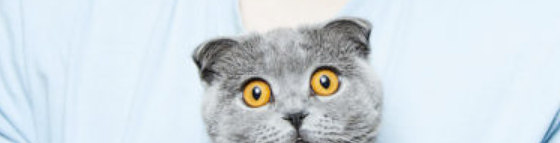

CPU times: total: 1.66 s
Wall time: 1.68 s


In [1]:
%%time
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from prophet import Prophet

from moexalgo import Ticker
import requests
from bs4 import BeautifulSoup
import os
import io
import time
from tqdm import tqdm
import datetime as dt
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore');
pd.options.display.float_format = '{:.2f}'.format

from IPython.display import display, Image
image_path = "img/1_.png"
display(Image(filename=image_path))

## 1. **ЗАГРУЗКА ДАННЫХ** 

In [2]:
# Загрузим тикеры топ-10 компаний ММВБ по капитализации 2023г.
URL = 'https://smart-lab.ru/q/shares_fundamental/?field=market_cap'
data = requests.get(URL).text
beautiful_soup = BeautifulSoup(data, 'html.parser')
tables = beautiful_soup.find_all('table')
top10 = pd.read_html(str(tables), index_col='№')[0].iloc[:10,[0, 1, 4]]
top10.head(3)

,Название,Тикер,"Капитализация, млрд руб"
№,,,
1,Сбербанк,SBER,6 566
2,Роснефть,ROSN,6 092
3,Лукойл,LKOH,4 949


In [114]:
%%time
# Загрузим исторические данные компаний (5min 8s)
# API MOEX выдает не более 20 тыс строк за раз, PS команды https://github.com/moexalgo/moexalgo/blob/main/samples/quick_start.ipynb
STOCK_LIST = top10['Тикер'].to_list()
START_DATE = 2015
STOP_DATE = pd.Timestamp.now()
os.makedirs('data', exist_ok=True)

def downloader(TICKER):
    #Инициализация
    data = Ticker(TICKER).candles(date=pd.to_datetime(str(START_DATE)), till_date=STOP_DATE, period='1h')
    for i in range(0, 100000):

        # Шаг вперед чтобы избежать наслоение периодов
        current_date = data.begin.max() + pd.Timedelta(1, unit='h')
        df = Ticker(TICKER).candles(date=current_date, till_date=STOP_DATE, period='1h')
        if df.empty:
            break

        # Объединяем в один
        data = pd.concat([data, df], ignore_index=True)
        print(f'{i+1}. {TICKER} - выполнение до {data.begin.max().date()}, осталось {(pd.Timestamp.now() - data.begin.max()).days} дней \nТекущий датасет {len(data)} строк\n')

    # Сохраним 
    path_data = f'data/{TICKER.lower()}_{TIMEFRAME}_{pd.to_datetime(str(START_DATE)).year}-{STOP_DATE.year}.csv'
    company_name = top10.set_index('Тикер').loc[TICKER]['Название']
    print(f'{company_name} загружен! Файл {path_data}\n')
    data.to_csv(path_data)
    print("------------------------------------------------------")

for TICKER in STOCK_LIST:
    downloader(TICKER)

1. SBER - выполнение до 2022-02-07, осталось 745 дней 
Текущий датасет 20000 строк
------------------------------------------------------
2. SBER - выполнение до 2024-02-22, осталось 0 дней 
Текущий датасет 26932 строк
------------------------------------------------------
Сбербанк загружен! Файл data/sber_h_2015-2024.csv

------------------------------------------------------
1. ROSN - выполнение до 2022-02-07, осталось 745 дней 
Текущий датасет 20000 строк
------------------------------------------------------
2. ROSN - выполнение до 2024-02-22, осталось 0 дней 
Текущий датасет 26927 строк
------------------------------------------------------
Роснефть загружен! Файл data/rosn_h_2015-2024.csv

------------------------------------------------------
1. LKOH - выполнение до 2022-02-07, осталось 745 дней 
Текущий датасет 20000 строк
------------------------------------------------------
2. LKOH - выполнение до 2024-02-22, осталось 0 дней 
Текущий датасет 26928 строк
---------------------

### **2 Подготовка таблицы с суммарной информацией по компаниям**


In [3]:
%%time
# Формируем таблицу суммарной инф. по компаниям для основного графика
sums_ = []

for filename in tqdm(os.listdir('data/'), desc='Расчет моделей', unit='file'):
    # Данные из файла
    file_ = pd.read_csv('data/' + filename)
    price = file_.iloc[-1]['close']
    date = file_.iloc[-1]['begin']
    name = filename.split('_')[0]
    
    # Импорт данных и обучение модели
    df = pd.DataFrame()
    df['ds'], df['y'] = pd.to_datetime(file_.begin), file_['close']
    
    # Обучение модели
    model = Prophet()
    model.fit(df)
    future = model.make_future_dataframe(periods=300)  # прогноз на 300 дней вперед
    forecast = model.predict(future)

    # Вносим данные в общий датафрейм
    final_prediction = forecast.iloc[-1]
    sums_.append({
        'name': name,
        'price': price,
        'predicted_price': final_prediction['yhat'],
        'lowest' : final_prediction['yhat_lower'],
        'highest' : final_prediction['yhat_upper'],
        'date': date_converter(date),
        'predicted_date': date_converter(final_prediction['ds'])
    })

    # Экспортируем данные прогноза для Streamlit
    os.makedirs('export/streamlit', exist_ok=True)
    forecast.to_csv(f'export/streamlit/{name}_forecast.csv')
    file_.to_csv(f'export/streamlit/{name}_data.csv')

    # Формируем имя компании для строки процесса
    company_name = top10.set_index('Тикер').loc[name.upper()]['Название']
    print(f'{company_name} завершен!\n')
    
# Создаем общий DataFrame
sums_ = pd.DataFrame(sums_)
sums_.set_index('name', inplace=True)

# Дополним датасет базовыми метриками:
# Выразим длительность прогноза в годах и потенциальный риск
prediction_duration = (pd.to_datetime(sums_.predicted_date) - pd.to_datetime(sums_.date)) / pd.to_timedelta(365, unit='D')
potential_risk = (sums_.lowest - sums_.price).mul(100) / sums_['price']

# Потенциальный риск и доходность в годовых %
sums_['potential_risk'] = potential_risk / prediction_duration
sums_['%_change'] = (sums_.predicted_price - sums_.price).mul(100) / sums_.price
sums_['potential_yield_return'] = sums_['%_change'] / prediction_duration

# Комбинируем влияния риск прибыль для сортировки датафрейма
sums_['sorting_col'] = sums_['potential_yield_return'] + sums_['potential_risk']
sums_ = sums_.sort_values('sorting_col', ascending=False).drop('sorting_col', axis=1)

# Экспорт
sums_.to_csv(f'export/streamlit/00_sums_data.csv')
print(f'Общий файл сформирован: export/streamlit/00_sums_data.csv\n')
sums_.head(3)


Расчет моделей:   0%|          | 0/11 [00:00<?, ?file/s]


KeyError: 'close'

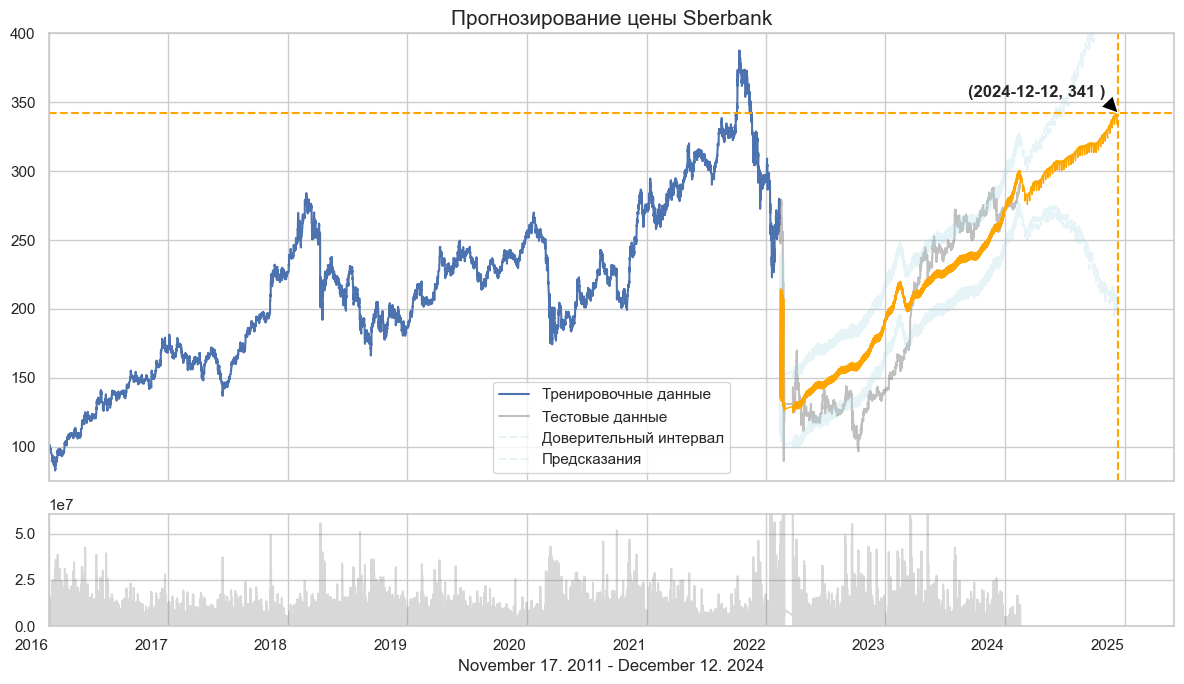

In [331]:
# Создаем макета с двумя подграфиками
sns.set(style="whitegrid")
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7), 
                        gridspec_kw={'height_ratios': [4, 1]}, 
                        sharex=True)

# Нанесение графика и доверительного интервала
train_df.set_index('ds').plot(ax=ax1)
test_df.set_index('ds').plot(ax=ax1, 
                        color='grey',
                        alpha=0.5)

forecast[['yhat_lower', 'yhat_upper', 'ds']] \
                        .set_index('ds')[train_df.index.max():] \
                        .plot(ax=ax1, 
                        color='lightblue', 
                        alpha=0.3, 
                        linestyle='--')

forecast[['yhat', 'ds']].set_index('ds')[train_df.index.max():] \
                        .plot(ax=ax1, 
                        color='orange', 
                        label='Предсказания', 
                        linewidth=1)

# Подписываем финальную точку предсказания
final_prediction = forecast.iloc[-1]
ax1.annotate(f'({final_prediction["ds"].date()}, {int(final_prediction["yhat"])} )', 
                        xy=(final_prediction["ds"], final_prediction["yhat"]), 
                        xytext=(final_prediction["ds"] - pd.Timedelta(days=40),final_prediction["yhat"]+10), 
                        fontsize=12,
                        weight='bold',
                        arrowprops=dict(facecolor='black', shrink=0), 
                        horizontalalignment='right',  # выравнивание по горизонтали
                        verticalalignment='bottom',  # выравнивание по вертикали
                        )

# Настройка легенды
ax1.legend(["Тренировочные данные", "Тестовые данные", 
            "Доверительный интервал", "Предсказания"])

# Пунктирные линии границ
ax1.axvline(future.iloc[-1].values, 
                        color='orange', 
                        ls='--', 
                        label=f'Граница прогнозирования')
ax1.axhline(forecast['yhat'].iloc[-1], 
                        color='orange', 
                        ls='--')

# Установка интервала осей, заголовка
ax1.set_title('Прогнозирование цены Sberbank', fontsize=15)
ax1.set_xlim(pd.Timestamp('2016-01-01'), pd.Timestamp('2025-06-01'))
ax1.set_ylim(75, 400)
ax2.set_xlim(pd.Timestamp('2016-01-01'), pd.Timestamp('2025-06-01'))
ax2.set_ylim(0, data['volume'].max()*0.4) # Масштабируем шкалу объема

# Построение графика объемов на втором подграфике
data.set_index('begin')['volume'] \
                        .plot(ax=ax2, 
                        color='grey', 
                        alpha=0.3)

# Установка параметров чертежа
plt.xlabel(f'{train_df.ds.dt.date.min().strftime("%B %d. %Y")} - {pd.to_datetime(future.iloc[-1].values).strftime("%B %d. %Y").item()}', fontsize=12) # Форматируемый диапазон дат под графиком
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## МОДЕЛИРОВАНИЕ И ЭКСПОРТ ДАННЫХ

In [259]:
# Выделим ключевые фундаментальные показатели компаний для таблицы корреляций
def most_important_params(income_, ticker):
    
    # Удаляем запятые и проценты из числовых данных
    income_ = income_.apply(lambda x: x.str.replace(',', '') if not pd.api.types.is_datetime64_any_dtype(x) else x)
    income_ = income_.apply(lambda x: x.str.replace('%', '') if not pd.api.types.is_datetime64_any_dtype(x) else x)
    
    # Удаляем ненужные столбцы и преобразуем данные в числовой формат
    income_ = income_.drop(['IR рейтинг', 'Качество фин.отчетности', 'Презентации для инвесторов',
                            'Присутствие на смартлабе', 'Годовой отчет', 'Сайт для инвесторов',
                            'Календарь инвесторов', 'Обратная связь', 'Дата отчета', 'Валюта отчета'],
                            axis=1).apply(lambda x: x.str.replace(' ', '').astype(float)
                            if not pd.api.types.is_datetime64_any_dtype(x) else x)

    # Инициализация общего итогового датасета
    result_df = pd.DataFrame(columns=['Корреляция', 'normalized_rmse'])

    # Фильтр по пропускам данных и дублирующим
    filtered_columns = income_.columns[income_.notna().sum() > 10]
    correlation = income_[filtered_columns].corr()['Капитализация, млрд руб'].abs().sort_values(ascending=False)
    best_columns = correlation.filter(regex='^(?!Цена акции|Капитализация|index)').head(10)
    print('\nМоделирование') # Строка состояния

    # Выделим насколько прогнозируемы данные через RMSE: 
    for column in best_columns.index:
        model = Prophet()
        
        # Разбиваем train test
        data = income_[['index', column]].rename(columns={'index': 'ds', column: 'y'}).dropna()
        split_train = int(0.8 * len(data))  # 80% для обучения 
        train_data, test_data = data[:split_train], data[split_train:]

        model.fit(train_data)
        future = model.make_future_dataframe(periods=len(test_data))
        forecast = model.predict(future)
        
        # Приводим RMSE к одному порядку величин
        rmse = np.sqrt(mean_squared_error(test_data['y'], forecast['yhat'][-len(test_data):]))
        mean_target = test_data['y'].mean()
        normalized_rmse = rmse / mean_target
        result_df.loc[column] = [correlation[column], normalized_rmse]
        
    # Создаем столбец для ранжирования признаков. 
    # RMSE становится поправочным коэфициентом для Корреляции при отборе лучших признаков
    result_df['normalized_rmse'] = 1 - (result_df['normalized_rmse'] / result_df['normalized_rmse'].max())
    result_df['combined_score'] = result_df['normalized_rmse'] * result_df['Корреляция']

    # Сортируем по новому признаку
    result_df_sorted = result_df.sort_values('combined_score', ascending=False)
    path_correlate_table = f'export\streamlit\{ticker.lower()}_correlation_table.csv'

    # Экспорт результатов
    result_df_sorted.to_csv(path_correlate_table)
    print(f'\nКоррелирующие параметры выделены. Файл {path_correlate_table}')
    return result_df_sorted

# Экспорт квартальных отчетностей для основного графика
def export_statment_data(income_, ticker):
    
    income_ = income_[['index','Чистая прибыль, млрд руб','Капитализация, млрд руб','P/E']].dropna()
    
    income_ = income_.rename(columns={'index':'ds','Чистая прибыль, млрд руб':'y'})
    income_[['y', 'Капитализация, млрд руб']] = income_[['y', 'Капитализация, млрд руб']].apply(lambda x: x.str.replace(' ', '').astype(float))
    path_income = f'export\streamlit\{ticker.lower()}_income.csv'
    # Сохраняем данные в файл CSV
    income_.to_csv(path_income)
    print(f'Отчетность выгружена. Файл {path_income}')
     
    export_forecast_income(income_, ticker)

# Прогноз дохода компаний и их экспорт для графика прогноза
def export_forecast_income(income_,ticker):

    # Обучение модели и прогнозирование
    p = Prophet()
    p.fit(income_[['ds', 'y']])
    future = p.make_future_dataframe(periods=10, freq='Q')
    forecast_income = p.predict(future)

    # Сохранение результатов в CSV-файлы
    path_forecast = f'export\streamlit\{ticker.lower()}_forcast_income.csv'
    forecast_income.to_csv(path_forecast)
    print(f'Прогноз дохода выполнен! Файл {path_forecast}\n')

In [262]:
# Список акций
STOCK_LIST = top10['Тикер'].to_list()
# Загрузка данных и прогнозирование для каждой акции
for ticker in tqdm(STOCK_LIST, desc='Загрузка данных'):
    print(f'{ticker} старт')
    
    # Получение данных
    response = requests.get(f'https://smart-lab.ru/q/{ticker}/f/q/MSFO/download/')
    income_ = pd.read_csv(io.BytesIO(response.content), sep=';')
    
    # Обрабатываем данные 
    income_ = income_.T.iloc[:-1]
    income_.columns = income_.iloc[0]
    income_.reset_index(inplace=True)
    income_ = income_.iloc[1:]
    income_['index'] = pd.to_datetime(income_['index']).dt.to_period('Q').dt.end_time

    # Моделирование и экспорт
    most_important_params(income_=income_,ticker=ticker)
    export_statment_data(income_=income_,ticker=ticker)
    time.sleep(1)
    print("------------------------------------------------------\n")

Загрузка данных:   0%|          | 0/10 [00:00<?, ?it/s]

SBER старт


DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
DEBUG:cmdstanpy:input tempfile: C:\Users\-\AppData\Local\Temp\tmp4r4ao64a\2jx62pdd.json
DEBUG:cmdstanpy:input tempfile: C:\Users\-\AppData\Local\Temp\tmp4r4ao64a\o89eib14.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\-\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=39563', 'data', 'file=C:\\Users\\-\\AppData\\Local\\Temp\\tmp4r4ao64a\\2jx62pdd.json', 'init=C:\\Users\\-\\AppData\\Local\\Temp\\tmp4r4ao64a\\o


Моделирование


20:17:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
DEBUG:cmdstanpy:input tempfile: C:\Users\-\AppData\Local\Temp\tmp4r4ao64a\9rw4b7el.json
DEBUG:cmdstanpy:input tempfile: C:\Users\-\AppData\Local\Temp\tmp4r4ao64a\blny9rgo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\-\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=90525', 'data', 'file=C:\\Users\\-\\AppData\\L


Коррелирующие параметры выделены. Файл export\streamlit\sber_correlation_table.csv
Отчетность выгружена. Файл export\streamlit\sber_income.csv


20:17:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Прогноз дохода выполнен! Файл export\streamlit\sber_forcast_income.csv



Загрузка данных:  10%|█         | 1/10 [00:07<01:05,  7.29s/it]

------------------------------------------------------

ROSN старт


DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
DEBUG:cmdstanpy:input tempfile: C:\Users\-\AppData\Local\Temp\tmp4r4ao64a\l4ftbzgq.json
DEBUG:cmdstanpy:input tempfile: C:\Users\-\AppData\Local\Temp\tmp4r4ao64a\h50e4zzt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\-\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=25890', 'data', 'file=C:\\Users\\-\\AppData\\Local\\Temp\\tmp4r4ao64a\\l4ftbzgq.json', 'init=C:\\Users\\-\\AppData\\Local\\Temp\\tmp4r4ao64a\\h


Моделирование


DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: C:\Users\-\AppData\Local\Temp\tmp4r4ao64a\osblsnnz.json
DEBUG:cmdstanpy:input tempfile: C:\Users\-\AppData\Local\Temp\tmp4r4ao64a\r8y2ed_6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\-\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=74930', 'data', 'file=C:\\Users\\-\\AppData\\Local\\Temp\\tmp4r4ao64a\\osblsnnz.json', 'init=C:\\Users\\-\\AppData\\Local\\Temp\\tmp4r4ao64a\\r


Коррелирующие параметры выделены. Файл export\streamlit\rosn_correlation_table.csv
Отчетность выгружена. Файл export\streamlit\rosn_income.csv


KeyboardInterrupt: 

In [248]:
# Визуализация
# Выберем лучшие 10 параметров
best_columns = correlation.head(10).index
selected_columns = income_[best_columns]
correlation_matrix = selected_columns.corr()

# Уберем все строки, кроме строки с 'Капитализация, млрд руб'
correlation_with_capitalization = correlation_matrix[['Капитализация, млрд руб']]

# Построим тепловую карту
plt.figure(figsize=(2, 4))  # Изменяем размер, чтобы было место только для одной строки
sns.heatmap(correlation_with_capitalization, annot=True, cmap='YlGnBu', fmt=".3f")
plt.title("Тепловая карта корреляции лучших параметров с 'Капитализация, млрд руб'")
plt.show()

KeyError: "None of [Index(['Капитализация, млрд руб', 'Цена акции ао, руб', 'Цена акции ап, руб',\n       'EV, млрд руб', 'Расх на персонал, млрд руб', 'EPS, руб',\n       'Чист. комисс. доход, млрд руб', 'Дост.осн капитала, %', 'index',\n       'Чистая прибыль, млрд руб'],\n      dtype='object', name='Unnamed: 0')] are in the [columns]"

In [118]:
%%time
# Загрузим данные квартальных отчетностей 
# Список тикеров
stock_list = top10['Тикер'].to_list()
# Получаем название компании по тикеру
company_name = top10.set_index('Тикер').loc[i]['Название']
for i in tqdm(stock_list, desc='Импорт отчетностей '):
    response = requests.get(f'https://smart-lab.ru/q/{i}/f/q/MSFO/download/')
    
    if response.status_code == 200:
        # Читаем CSV данные из ответа
        income_data = pd.read_csv(io.BytesIO(response.content), sep=';')
        
        # Обрабатываем данные
        income_data = income_data.iloc[[0, 7, 10]].T.dropna().iloc[1:-1].reset_index()
        income_data['index'] = pd.to_datetime(income_data['index']).dt.to_period('Q').dt.end_time
        income_data = income_data.rename(columns={'index':'ds','Чистая прибыль, млрд руб':'y'})

        # Сохраняем данные в файл CSV
        income_data.to_csv(filename)
        print(f'{company_name} готов! Файл загружен{filename}')

        company_name = top10.set_index('Тикер').loc[i]['Название']
        forecasting_income(i, income_data, company_name)
        # Получаем название компании по тикеру
        print(f'{i} готов! Файл загружен{filename}')
    else:
        print("Ошибка при загрузке файла:", response.status_code)

def forecasting_income(ticker, data):
    data = data.rename(columns={'index':'ds','Чистая прибыль, млрд руб':'y'})
    p = Prophet()
    p.fit(data[['ds', 'y']])
    future = p.make_future_dataframe(periods=10, freq='Q')
    forecast_income = p.predict(future)
    filename = f'export\streamlit\{ticker.lower()}_forcast_income.csv'
    forecast_income.to_csv(filename)
    print(f'{i} прогноз дохода выполнен! Файл {filename}')
    print(f'{company_name} готов! Файл загружен{filename}')

Импорт отчетностей :   0%|          | 0/10 [00:06<?, ?it/s]

Сбербанк готов! Файл загруженexport\streamlit\plzl_dividend_table.csv


TypeError: forecasting_income() takes 2 positional arguments but 3 were given

In [115]:
%%time
# Загрузим дивидендные истории компаний 
# Задаем список тикеров
STOCK_LIST = top10['Тикер'].to_list()

# Запускаем итерацию по тикерам
for ticker in tqdm(STOCK_LIST, desc='Выполнение'):
    print(f'{ticker}')
    
    # Формируем URL для загрузки данных о дивидендах
    URL = f'https://www.dohod.ru/ik/analytics/dividend/{ticker.lower()}'
    data = requests.get(URL).text
    beautiful_soup = BeautifulSoup(data, 'html.parser')
    tables = beautiful_soup.find_all('table')

    # Извлекаем данные о дивидендах и обрабатываем их
    dividends = pd.read_html(str(tables))[2].iloc[:,[0,1,3]]
    dividends.iloc[:,:2] = dividends.iloc[:,:2].applymap(lambda x: str(x).rstrip(' (прогноз)'))
    dividends.iloc[:,:2] = dividends.iloc[:,:2].applymap(lambda x: pd.to_datetime(x).date())
    to_export_prophet = dividends.rename(columns={'Дата закрытия реестра':'ds','Дивиденд':'y'})
    to_export_prophet.iloc[:,:2] = to_export_prophet.iloc[:,:2].applymap(lambda x: pd.to_datetime(x).to_period('Q').end_time if pd.isna(x) != True else x)
    # Обучаем модель Prophet и делаем предсказание
    model = Prophet()
    model.fit(to_export_prophet[['ds', 'y']])
    future = model.make_future_dataframe(periods=10, freq='Q')
    to_export_prophet = model.predict(future)
    
    # Экспортируем отдельно предсказанные данные 
    filename = f'export\streamlit\{ticker.lower()}_forcast_dividend.csv'
    to_export_prophet.to_csv(filename)
    print(f'Прогноз дивидендов готов! Файл {filename}')

    # Экспортируем отдельн исторические данные о дивидендах
    dividends.columns = ['Объяв. див.', 'Закр. реестра', 'Дивиденд']
    filename = f'export\streamlit\{ticker.lower()}_dividend_table.csv'
    dividends.to_csv(filename)
    print(f'Див история готова! Файл {filename}')
    print("------------------------------------------------------")

Выполнение:   0%|          | 0/10 [00:00<?, ?it/s]

SBER


22:04:47 - cmdstanpy - INFO - Chain [1] start processing
22:04:48 - cmdstanpy - INFO - Chain [1] done processing
Выполнение:  10%|█         | 1/10 [00:01<00:15,  1.77s/it]

SBER прогноз дивидендов готов! Файл export\streamlit\sber_forcast_dividend.csv
SBER див история готова! Файл export\streamlit\sber_dividend_table.csv
------------------------------------------------------
ROSN


22:04:49 - cmdstanpy - INFO - Chain [1] start processing
22:04:50 - cmdstanpy - INFO - Chain [1] done processing
Выполнение:  20%|██        | 2/10 [00:03<00:14,  1.87s/it]

ROSN прогноз дивидендов готов! Файл export\streamlit\rosn_forcast_dividend.csv
ROSN див история готова! Файл export\streamlit\rosn_dividend_table.csv
------------------------------------------------------
LKOH


22:04:51 - cmdstanpy - INFO - Chain [1] start processing
22:04:51 - cmdstanpy - INFO - Chain [1] done processing
Выполнение:  30%|███       | 3/10 [00:05<00:12,  1.80s/it]

LKOH прогноз дивидендов готов! Файл export\streamlit\lkoh_forcast_dividend.csv
LKOH див история готова! Файл export\streamlit\lkoh_dividend_table.csv
------------------------------------------------------
NVTK


22:04:53 - cmdstanpy - INFO - Chain [1] start processing
22:04:53 - cmdstanpy - INFO - Chain [1] done processing
Выполнение:  40%|████      | 4/10 [00:07<00:10,  1.78s/it]

NVTK прогноз дивидендов готов! Файл export\streamlit\nvtk_forcast_dividend.csv
NVTK див история готова! Файл export\streamlit\nvtk_dividend_table.csv
------------------------------------------------------
GAZP


22:04:56 - cmdstanpy - INFO - Chain [1] start processing
22:04:57 - cmdstanpy - INFO - Chain [1] done processing
Выполнение:  50%|█████     | 5/10 [00:10<00:12,  2.41s/it]

GAZP прогноз дивидендов готов! Файл export\streamlit\gazp_forcast_dividend.csv
GAZP див история готова! Файл export\streamlit\gazp_dividend_table.csv
------------------------------------------------------
SIBN


22:05:00 - cmdstanpy - INFO - Chain [1] start processing
22:05:00 - cmdstanpy - INFO - Chain [1] done processing
Выполнение:  60%|██████    | 6/10 [00:14<00:11,  2.82s/it]

SIBN прогноз дивидендов готов! Файл export\streamlit\sibn_forcast_dividend.csv
SIBN див история готова! Файл export\streamlit\sibn_dividend_table.csv
------------------------------------------------------
GMKN


22:05:02 - cmdstanpy - INFO - Chain [1] start processing
22:05:02 - cmdstanpy - INFO - Chain [1] done processing
Выполнение:  70%|███████   | 7/10 [00:16<00:07,  2.54s/it]

GMKN прогноз дивидендов готов! Файл export\streamlit\gmkn_forcast_dividend.csv
GMKN див история готова! Файл export\streamlit\gmkn_dividend_table.csv
------------------------------------------------------
TATN


22:05:04 - cmdstanpy - INFO - Chain [1] start processing
22:05:04 - cmdstanpy - INFO - Chain [1] done processing
Выполнение:  80%|████████  | 8/10 [00:17<00:04,  2.26s/it]

TATN прогноз дивидендов готов! Файл export\streamlit\tatn_forcast_dividend.csv
TATN див история готова! Файл export\streamlit\tatn_dividend_table.csv
------------------------------------------------------
SNGS


22:05:07 - cmdstanpy - INFO - Chain [1] start processing
22:05:07 - cmdstanpy - INFO - Chain [1] done processing
Выполнение:  90%|█████████ | 9/10 [00:21<00:02,  2.60s/it]

SNGS прогноз дивидендов готов! Файл export\streamlit\sngs_forcast_dividend.csv
SNGS див история готова! Файл export\streamlit\sngs_dividend_table.csv
------------------------------------------------------
PLZL


22:05:09 - cmdstanpy - INFO - Chain [1] start processing
22:05:09 - cmdstanpy - INFO - Chain [1] done processing
Выполнение: 100%|██████████| 10/10 [00:22<00:00,  2.29s/it]

PLZL прогноз дивидендов готов! Файл export\streamlit\plzl_forcast_dividend.csv
PLZL див история готова! Файл export\streamlit\plzl_dividend_table.csv
------------------------------------------------------
CPU times: total: 4.97 s
Wall time: 22.9 s


In [7]:
# Получаем HTML-контент с указанного URL
for i in tqdm(top10):
    URL = f'https://www.dohod.ru/ik/analytics/dividend/{i}'
    data = requests.get(URL).text
    beautiful_soup = BeautifulSoup(data, 'html.parser')
    tables = beautiful_soup.find_all('table')
    dividends = pd.read_html(str(tables))[2].iloc[:,[0,1,3]]

    # Исправление данных
    dividends.iloc[0, 0] = dividends.iloc[1, 0][:-1] + '4'
    dividends.iloc[0, 1] = dividends.iloc[0, 1].rstrip(' (прогноз)')
    dividends.iloc[:,:2] = dividends.iloc[:,:2] \
                            .astype('datetime64[ms]')

    dividends['Дата объявления дивиденда'], dividends['Дата закрытия реестра'] = dividends['Дата объявления дивиденда'].dt.strftime("%b %d, %Y"), dividends['Дата закрытия реестра'].dt.strftime("%b %d, %Y")
    dividends.rename(columns={'Дата объявления дивиденда': 'Объяв. див.', 'Дата закрытия реестра': 'Закр. реестра'}, inplace=True).iloc[0:10]
    dividends.to_csv(f'export\streamlit\{i}_dividends.csv')

ValueError: No tables found